In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import math
import sklearn
import tarfile
import urllib.request

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [4]:
# Loading in the California Housing Prices Dataset. 
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [44]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Before we do any splitting or analysis on the data, we first want to check some of the descriptive statistics. This is to ensure that we do not have any uninformative values or null values. Additionally, we want to check for missing data in the dataset. We would want to find a way to deal with the missing values, and in the context of this, possibly impute some of the values. 

In [45]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [66]:
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

We observe that all of the variables here are numeric, except for 1, which is the ocean proximity.

In [69]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [133]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

housing_oceanprox = housing_oceanprox[['ocean_proximity']]
onehot_encoder = OneHotEncoder()
housing_onehot = onehot_encoder.fit_transform(housing_oceanprox)
onehot_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [136]:
housing_OHoceanprox = pd.DataFrame(housing_onehot.toarray(), columns = ['1HOCEAN','INLAND','ISLAND','NEARBAY','NEAROCEAN'])

,1HOCEAN,INLAND,ISLAND,NEARBAY,NEAROCEAN
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
20635,0.0,1.0,0.0,0.0,0.0
20636,0.0,1.0,0.0,0.0,0.0
20637,0.0,1.0,0.0,0.0,0.0
20638,0.0,1.0,0.0,0.0,0.0


To avoid multicolinearity when using KNN regression, we drop the column NEAROCEAN from the dataset. 

In [140]:
housing_full = pd.concat([housing.drop('ocean_proximity', axis=1), housing_OHoceanprox.iloc[:,:4]], axis=1)
housing_full

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1HOCEAN,INLAND,ISLAND,NEARBAY
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.0,0.0,0.0,1.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.0,0.0,0.0,1.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.0,0.0,0.0,1.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.0,0.0,0.0,1.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,0.0,1.0,0.0,0.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,0.0,1.0,0.0,0.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,0.0,1.0,0.0,0.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,0.0,1.0,0.0,0.0


In [142]:
# Check for any missing values in the dataset.

def missing_value_test(dataset):
    missing_value = np.array(dataset.isnull().sum())
    colnames = dataset.columns
    df = pd.DataFrame(missing_value, index=colnames, columns = ['missing_values']).T
    return(df)

missing_value_test(housing_full)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1HOCEAN,INLAND,ISLAND,NEARBAY
missing_values,0,0,0,0,207,0,0,0,0,0,0,0,0


Looks like we have 207 missing values for the variable total bedrooms. Therefore, we try to impute these values by using some of the techniques and in built functions in Scikit, exploring both the KNN imputer and the Simple Imputer using median. To further analyse these observations, we pick out the indexes.

In [143]:
incomplete_rows = housing_full[housing_full.isnull().any(axis=1)].index
print(incomplete_rows)

Int64Index([  290,   341,   538,   563,   696,   738,  1097,  1350,  1456,
             1493,
            ...
            19932, 19959, 20046, 20069, 20125, 20267, 20268, 20372, 20460,
            20484],
           dtype='int64', length=207)


In [144]:
from sklearn.impute import SimpleImputer, KNNImputer

# Call the impute functions
median_imputer = SimpleImputer(strategy="median")
KNN_imputer = KNNImputer(n_neighbors = 3)

In [164]:
# Fit the imputers, and then check the rows that were imputed.
housing_clean_knn = pd.DataFrame(KNN_imputer.fit_transform(housing_full), columns=KNN_imputer.get_feature_names_out())
housing_clean_median = pd.DataFrame(median_imputer.fit_transform(housing_full), columns=KNN_imputer.get_feature_names_out())
housing_clean_median.iloc[incomplete_rows].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1HOCEAN,INLAND,ISLAND,NEARBAY
290,-122.16,37.77,47.0,1256.0,435.0,570.0,218.0,4.3750,161900.0,0.0,0.0,0.0,1.0
341,-122.17,37.75,38.0,992.0,435.0,732.0,259.0,1.6196,85100.0,0.0,0.0,0.0,1.0
538,-122.28,37.78,29.0,5154.0,435.0,3741.0,1273.0,2.5762,173400.0,0.0,0.0,0.0,1.0
563,-122.24,37.75,45.0,891.0,435.0,384.0,146.0,4.9489,247100.0,0.0,0.0,0.0,1.0
696,-122.10,37.69,41.0,746.0,435.0,387.0,161.0,3.9063,178400.0,0.0,0.0,0.0,1.0


In [166]:
housing_clean_knn.iloc[incomplete_rows].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1HOCEAN,INLAND,ISLAND,NEARBAY
290,-122.16,37.77,47.0,1256.0,241.333333,570.0,218.0,4.3750,161900.0,0.0,0.0,0.0,1.0
341,-122.17,37.75,38.0,992.0,274.333333,732.0,259.0,1.6196,85100.0,0.0,0.0,0.0,1.0
538,-122.28,37.78,29.0,5154.0,1299.666667,3741.0,1273.0,2.5762,173400.0,0.0,0.0,0.0,1.0
563,-122.24,37.75,45.0,891.0,166.333333,384.0,146.0,4.9489,247100.0,0.0,0.0,0.0,1.0
696,-122.10,37.69,41.0,746.0,164.666667,387.0,161.0,3.9063,178400.0,0.0,0.0,0.0,1.0


We can see the numerical values that were imputed using both functions, and for the purposes of KNN regression that we will do later, we choose the dataset that was imputed using KNN. We also would like to scale the dataset, as distance-based models are sensitive to the scale of the features, where instances with larger values would have an abnormally skewed bias towards them.

In [189]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
std_scaler = StandardScaler() # call the scaler function

num_pipeline = Pipeline([ # pipeline for scaling the data
    ('std_scaler', StandardScaler())
])

# Function to transform given data to scaled, 
def scale_data(data):
    data_tr = num_pipeline.fit_transform(data)
    data_tr_scaled = pd.DataFrame(data_tr, columns=data.columns)
    return(data_tr_scaled)

housing_clean_knn_scaled = scale_data(housing_clean_knn)

Splitting the data into training and test sets, using a 80:20 ratio.

In [190]:
# Split the data into the Y dependent variable and X predictor variable;
Y_data = housing_clean_knn_scaled['median_house_value']
X_data = housing_clean_knn_scaled.drop('median_house_value', axis=1)

In [191]:
# Split the data into training and test sets (80/20) split
from sklearn.model_selection import train_test_split

train_X, test_X, train_Y, test_Y = train_test_split(X_data, Y_data, test_size = 0.2)

In [210]:
from sklearn.neighbors import KNeighborsRegressor

# Applying the k-NN Algorithm, default neighbours = 5 and uniform distance.
knn_regress_model = KNeighborsRegressor(n_neighbors=5)
knn_regress_model.fit(train_X, train_Y)
predicted_train_X = knn_regress_model.predict(train_X)
predicted_test_X = knn_regress_model.predict(test_X)

In [219]:
from sklearn.metrics import mean_squared_error

train_knn_mse, test_knn_mse = mean_squared_error(predicted_train_X, train_Y),  mean_squared_error(predicted_test_X, test_Y)
train_knn_rmse, test_knn_rmse = np.sqrt(knn_mse), np.sqrt(knn_rmse)
print(train_knn_rmse, test_knn_rmse)

0.4324029573622999 0.6575735376080001


Extra bits, playing with PCA for dimensionality reduction.

In [206]:
# Playing with Principal Components
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
X = pca_model.fit_transform(housing_clean_knn_scaled)
pca_model.components_[0]

array([ 0.10204664, -0.10462197, -0.21657958,  0.4780736 ,  0.48338156,
        0.46659457,  0.48518769,  0.06242508,  0.05386049,  0.06619372,
       -0.02589899, -0.00530377, -0.06727545])

In [207]:
X

array([[-2.21212565,  0.3606421 ],
       [ 2.71568054,  1.53321384],
       [-2.14728721,  0.71572412],
       ...,
       [-0.66871846,  2.6705145 ],
       [-1.07898173,  2.61625176],
       [-0.0816924 ,  2.69214246]])

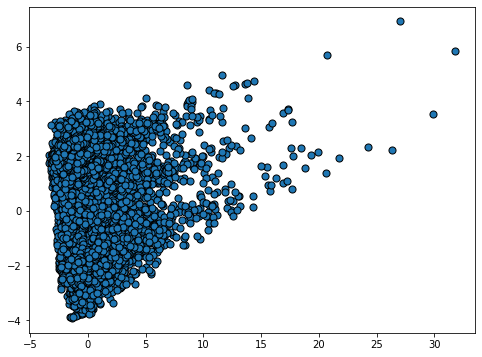

In [208]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], edgecolor='k', s=50)